# Librerías

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import string
import re
import io
import json

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D


# Datos

Se importan y concatenan las distintas fuentes de datos.

In [8]:
data = pd.DataFrame([])

data_path = "dataset"
filenames = os.listdir(data_path)
for filename in filenames:
    if filename.endswith(".csv"):
        csv_file = pd.read_csv(os.path.join(data_path, filename))
        data = pd.concat([data, csv_file])
        
data.reset_index(inplace=True, drop=True)
data

,title,text,word_count,category,source
0,Astronomaycienciageneralcoleccindetrabajoscien...,\n \n \n \n \n\n \n \n \n\n \n \n Índice \n ...,187635,Ciencias,epub
1,Elmecanismodelareaccinqumicadiscursoledoenlaso...,\n \n \n \n \n\n \n \n \n\n \n \n Índice \n ...,9797,Ciencias,epub
2,ElmundodelosvegetalesTextoimpresofenmenosymist...,\n \n \n \n \n\n \n \n \n\n \n \n Índice \n ...,48946,Ciencias,epub
3,Hongoscomestiblesyvenenosos,\n \n \n \n \n\n \n \n \n\n \n \n Índice \n ...,27725,Ciencias,epub
4,LateoriadarwinianaylaCreacinllamadaindependiente,\n \n \n \n \n\n \n \n \n\n \n \n Índice \n ...,83198,Ciencias,epub
...,...,...,...,...,...
112,imperio,"Un imperio (del latín, imperium) es una ""unida...",1627,Historia,wiki
113,batalla,Una batalla se podría definir como un combate ...,3728,Historia,wiki
114,arqueología,"La arqueología (del griego «ἀρχαίος» archaios,...",5167,Historia,wiki
115,cronología,Cronología (del griego χρόνος crónos ‘tiempo’...,6947,Historia,wiki


# Limpieza

La limpieza consiste en:
* Convertir todos los textos a minúscula
* Eliminar stopswords, números y signos de puntuación
* Obtener los lemas de las palabras
* Crea sentencias con los saltos de línea, para obtener textos mas cortos.
* Eliminar registros con menos de 10 palabras

Retorna el DataFrame limpio donde podemos averiguar la cantidad de registros, la longitud máxima de las sentencias y la longitud promedio. Estos últimos valores los necesitamos conocer para saber dónde podemos truncar las sentencias.

In [9]:
# Descargas necesarias
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw')
# nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ayo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\Ayo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

In [10]:
def clean_df(df):
  
    df = df.copy()
    
    # Convertir todo a minúsculas
    df['text'] = df['text'].str.lower()
    
    # Eliminamos signos de puntuación y números
    punctuation = string.punctuation + "¡¿«»©"
    df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans(punctuation, " " * len(punctuation))))
    
    # Eliminar palabras que contienen caracteres diferentes al español
    pattern = re.compile(r'^[a-záéíóúüñ]+$')
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if pattern.match(word)]))
    
    # Eliminar stopwords
    stop_words = set(stopwords.words(['spanish', 'english']))
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    
    # Obtener lemas de las palabras
    lemmatizer = WordNetLemmatizer()
    df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    
    # Volver a contar palabras
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    
    return df

In [11]:
df = clean_df(data)
df

,title,text,word_count,category,source
0,Astronomaycienciageneralcoleccindetrabajoscien...,índice cubierta portada preliminares astronomí...,100030,Ciencias,epub
1,Elmecanismodelareaccinqumicadiscursoledoenlaso...,índice cubierta portada preliminares mecanismo...,5033,Ciencias,epub
2,ElmundodelosvegetalesTextoimpresofenmenosymist...,índice cubierta portada preliminares mundo veg...,26442,Ciencias,epub
3,Hongoscomestiblesyvenenosos,índice cubierta portada preliminares hongos co...,15119,Ciencias,epub
4,LateoriadarwinianaylaCreacinllamadaindependiente,índice cubierta portada preliminares teoría da...,43025,Ciencias,epub
...,...,...,...,...,...
112,imperio,imperio latín imperium unidad política formada...,918,Historia,wiki
113,batalla,batalla podría definir combate do contendiente...,1927,Historia,wiki
114,arqueología,arqueología griego archaios viejo antiguo logo...,2675,Historia,wiki
115,cronología,cronología griego crónos lógos ciencias auxili...,3242,Historia,wiki


In [40]:
# Se guardan los textos filtrados
df.to_csv('df_normalized.csv', index=False)

In [12]:
df[df['word_count'] < 1000]

,title,text,word_count,category,source
80,economía,economía griego oikos casa reparto distribució...,545,Sociales,wiki
82,elecciones,elecciones comicios proceso institucional elec...,949,Sociales,wiki
91,espiritualidad,término espiritualidad latín spiritus espíritu...,950,Religión,wiki
92,doctrina,doctrina latín conjunto global concepciones te...,754,Religión,wiki
95,sagrado,sagrado latín considera digno veneración u obj...,965,Religión,wiki
112,imperio,imperio latín imperium unidad política formada...,918,Historia,wiki


In [13]:
# cantidad de registros
cant_registros = df.shape[0]
print("Cantidad de registros:", cant_registros)

# maxima longitud de texto
max_longitud = max(df['text'].apply(lambda x: len(x.split())))
print("Longitud máxima de palabras:", max_longitud)

# minima longitud de texto
max_longitud = min(df['text'].apply(lambda x: len(x.split())))
print("Longitud mínima palabras:", max_longitud)

# longitud promedio de texto
mean_longitud = round(np.mean(df['text'].apply(lambda x: len(x.split()))))
print("Longitud media palabras:", mean_longitud)

Cantidad de registros: 117
Longitud máxima de palabras: 511665
Longitud mínima palabras: 545
Longitud media palabras: 39424


# Separación de datos en train, validation y test

En primer lugar, necesitamos que las sentencias, las etiquetas de cada sentencia y las categorías que tenemos se guarden en una lista. Para ello, usamos la función `obtener_datos_etiquetas`.

In [14]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['category'])
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['category'])

In [15]:
print(len(df_train))
print(len(df_test))
print(len(df_val))

74
24
19


## Acondicionamiento de los datos: Tokenización


Para poder utilizar NLP, es necesario hacer algunos pasos para acondicionarlos.

En primer lugar se usa la función `fit_tokenizer` que toma como entrada un conjunto de textos y ajusta el tokenizador ara que pueda entender y representar correctamente el vocabulario de esos textos. Un tokenizador es una herramienta que se utiliza para dividir el texto en unidades más pequeñas, llamadas tokens. Estos tokens pueden ser palabras individuales, caracteres, subpalabras, etc.

Durante el ajuste, el tokenizador analiza los textos y construye un vocabulario, asignando un índice único a cada token.

In [16]:
# Parámetros
max_words = 10000  # Número máximo de palabras a considerar
max_len = 500  # Longitud máxima de las secuencias de texto
embedding_dim = 128  # Dimensión del embedding

In [17]:
# Preprocesamiento de textos
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train['text'].tolist())

In [46]:
tokenizer_json = tokenizer.to_json()
with io.open('models/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [53]:
with open('models/tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

A continuación, es necesario convertir una lista de textos en secuencias numéricas y luego realizar el relleno de secuencias (padding) para que todas las secuencias tengan la misma longitud

In [55]:
train_sequences = tokenizer.texts_to_sequences(df_train['text'])
test_sequences = tokenizer.texts_to_sequences(df_test['text'])
val_sequences = tokenizer.texts_to_sequences(df_val['text'])

In [56]:
X_train = pad_sequences(train_sequences, maxlen=max_len)
X_test = pad_sequences(test_sequences, maxlen=max_len)
X_val = pad_sequences(val_sequences, maxlen=max_len)

In [57]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(74, 500)
(24, 500)
(19, 500)


In [21]:
train_labels = df_train['category']
test_labels = df_test['category']
val_labels = df_val['category']

In [22]:
label_encoder = LabelEncoder()
label_encoder.fit(df_train['category'])
categories = list(label_encoder.classes_)
print(categories)
y_train = label_encoder.transform(df_train['category'])
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(categories))
y_val = label_encoder.transform(df_val['category'])
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(categories))
y_test = label_encoder.transform(df_test['category'])
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(categories))


['Ciencias', 'Historia', 'Religión', 'Sociales']


In [74]:
label_encoder.classes_

array(['Ciencias', 'Historia', 'Religión', 'Sociales'], dtype=object)

In [75]:
# Guardar el label encoder
label_encoder_data = {'classes': label_encoder.classes_.tolist()}
with open('models/label_encoder.json', 'w') as f:
    json.dump(label_encoder_data, f)

In [73]:
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(74, 4)
(24, 4)
(19, 4)


## Modelo de clasificación de texto

A continuación, creamos el modelo que usaremos en el entrenamiento. Para ello usamos la función `crear_modelo`.

En este caso se eligió un modelo sequencial de tensorflow compuesto por las siguientes capas:

* **Capa de Embedding**: Esta capa se encarga de mapear las palabras del vocabulario a vectores de números reales de longitud `embedding_dim`. Los parámetros `num_words`, `embedding_dim` y `maxlen` son utilizados para definir los atributos de esta capa. `num_words` representa el tamaño del vocabulario, `embedding_dim` especifica la dimensión de los vectores de embedding y `maxlen` es la longitud máxima de las secuencias de entrada.

* **Capa LSTM**: Esta capa contiene una capa LSTM que procesa la secuencia de entrada de forma recurrente 

* **Capas Dense**: Capa auxiliares

* **Capa Dropout**: Capa auxiliar


* **Capa Densa**: Esta es la capa de salida del modelo y tiene una función de activación softmax. Mapea las salidas de la capa anterior a las probabilidades de pertenecer a cada una de las categorías. El parámetro `num_categories` define el número de categorías de salida.

Finalmente, se utiliza el método `compile` para configurar la etapa de compilación de un modelo en Keras, donde se especifican la funció de pérdida, el algoritmo de optimización y las métricas adoptadas.

In [60]:
# Definición del modelo
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
# model.add(SpatialDropout1D(0.2))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
# model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
# model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(len(categories), activation='softmax'))

# Compilación del modelo
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


c:\Users\Ayo\anaconda3\envs\proyecto\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Finalmente, se utiliza el método `fit` para entrenar el modelo con los datos de entrenamiento y validar su rendimiento con los datos de validación.

En este punto es donde se inicia el proceso de entrenamiento del modelo. Durante cada época, se ajustan los pesos del modelo utilizando el algoritmo de optimización especificado, se calcula la función de pérdida en los datos de entrenamiento y se evalúa el rendimiento del modelo en los datos de validación. El historial del entrenamiento, incluyendo las métricas y pérdidas calculadas en cada época, se guarda en el objeto `history`.

In [61]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 778ms/step - accuracy: 0.2313 - loss: 1.3865 - val_accuracy: 0.3158 - val_loss: 1.3859
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 476ms/step - accuracy: 0.5232 - loss: 1.3674 - val_accuracy: 0.3684 - val_loss: 1.3897
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step - accuracy: 0.4147 - loss: 1.3377 - val_accuracy: 0.3684 - val_loss: 1.3954
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step - accuracy: 0.4559 - loss: 1.2931 - val_accuracy: 0.3684 - val_loss: 1.3983
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - accuracy: 0.7081 - loss: 1.1645 - val_accuracy: 0.3158 - val_loss: 1.4622
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step - accuracy: 0.7649 - loss: 0.9490 - val_accuracy: 0.2632 - val_loss: 1.4010
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 516ms/step - accuracy: 0.7934 - loss: 0.7511 - val_accuracy: 0.4211 - val_loss: 1.3863
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step - accuracy: 0.8204 - loss: 0.6257 - val_accuracy: 0.4211 - val_loss:

In [62]:
# Evaluación del modelo
loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f'Loss: {loss}, Accuracy: {accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.4737 - loss: 1.6305
Loss: 1.6304872035980225, Accuracy: 0.4736842215061188


In [63]:
# Evaluación del modelo
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Loss: {loss}, Accuracy: {accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.4583 - loss: 2.4985
Loss: 2.498479127883911, Accuracy: 0.4583333432674408


## Evaluación del modelo

Con la función `eval_model` podemos ver gráficamente cómo cambian la precisión y la pérdida durante las épocas de entrenamiento. Toma el historial de entrenamiento (`history`) como entrada y extrae las métricas de precisión y pérdida de las épocas de entrenamiento y validación.

In [64]:
def eval_model(history):
    # Almacena las precisiones y pérdidas para el entrenamiento y validación
    epoch_accuracy = history.history['accuracy']
    epoch_val_accuracy = history.history['val_accuracy']
    epoch_loss = history.history['loss']
    epoch_val_loss = history.history['val_loss']

    plt.figure(figsize=(20, 6))

    # Grafica la precisión en el entrenamiento y validación
    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(epoch_accuracy)), epoch_accuracy, 'b-', linewidth=2, label='Precisión en Entrenamiento')
    plt.plot(range(0, len(epoch_val_accuracy)), epoch_val_accuracy, 'r-', linewidth=2, label='Precisión en Validación')
    plt.title('Precisión en Entrenamiento y Validación por epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Precisión')
    plt.legend(loc='best')

    # Grafica la pérdida en el entrenamiento y validación
    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Pérdida en Entrenamiento')
    plt.plot(range(0, len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Pérdida en Validación')
    plt.title('Pérdida en Entrenamiento y Validación por epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

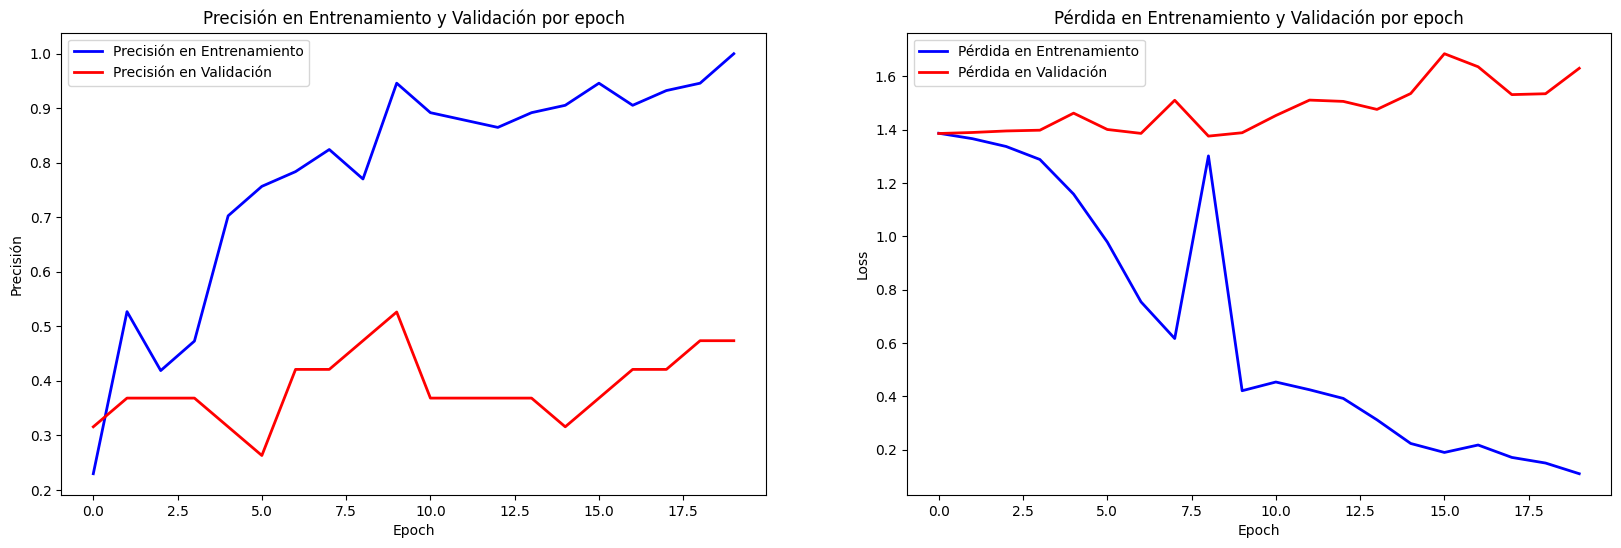

In [65]:
# Usamos la función para evaluarlo
eval_model(history)

In [66]:
# Guardar el modelo en un archivo .h5
model_name = 'models/model_mix_dataset.h5'
model.save(model_name)

print(f"Modelo guardado como {model_name}")

Modelo guardado como models/model_mix_dataset.h5


Otra forma de evaluar el modelo es usando el subconjunto de testeo para ver el rendimiento sobre datos nunca vistos durante el entenamiento. Para ello se usa el método `evaluate`.

## Predicciones

In [67]:
pred = list(model.predict(X_test).argmax(axis=1))
real = list(y_test.argmax(axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


In [69]:
# Y finalmente visualizamos la Matriz de Confusión, para lo que se crea la siguiente función, que se llamará más adelante
# y_true     : dataframe -> Los valores de las clases que son ciertos (test)
# y_pred     : ndarray   -> Los valores calculados de las clases después de realizar la predicción
# classes    : ndarray   -> Los nombres de las clases/valores objetivos como array de numpy
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          titleSup=None,
                          fig=None,
                          ax=None):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if not fig:
      fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=titleSup,
           ylabel='True label',
           xlabel='Predicted label')
    ax.annotate(title, xy=(0.5, 1.1), xytext=(0, 10),
            xycoords='axes fraction', textcoords='offset points',
            ha='center', va='baseline', fontsize=10)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        title = 'Matriz de Confusión'
    else:
        title = 'Matriz de Confusión'

    fig.tight_layout()
    fig.suptitle(title, fontsize=16, y=1, ha='center')
    return ax

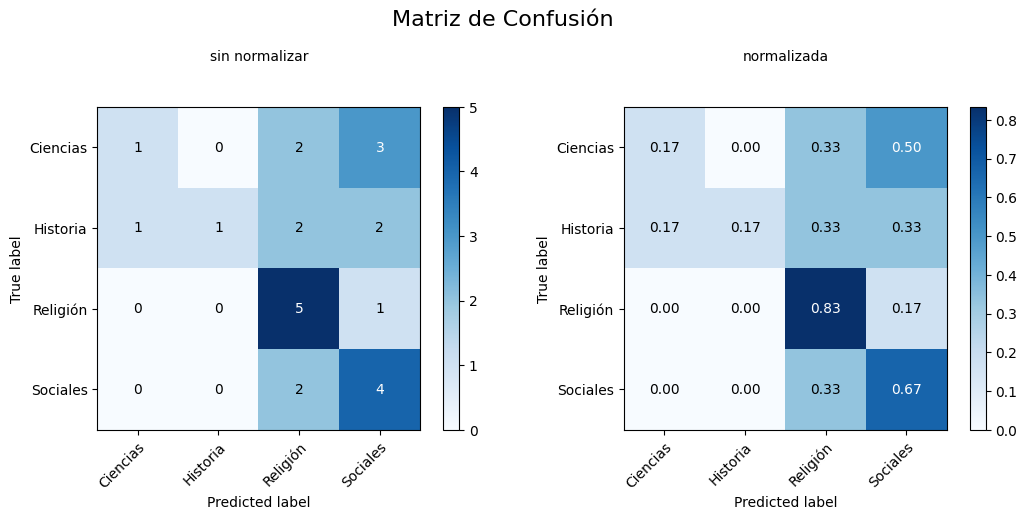

In [70]:
# Creamos el contenedor para representar los resultados
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (11,5))

# Creamos este array de numpy porque es el parámetro con las clases que espera la función
plot_confusion_matrix(real,
                      pred,
                      classes=np.array(categories),
                      normalize=False,
                      title='sin normalizar',
                      titleSup="",
                      fig=fig,
                      ax=ax[0]);

# Creamos este array de numpy porque es el parámetro con las clases que espera la función
plot_confusion_matrix(real,
                      pred,
                      classes=np.array(categories),
                      normalize=True,
                      title='normalizada',
                      titleSup="",
                      fig=fig,
                      ax=ax[1]);